<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

Note: This is part 1 of the code notebook covering the following :-
1. [Problem Statement](#1.-Problem-Statement)
2. [Background](#2.-Background)
3. [Library Imports & Functions Creation](#3.-Library-Imports-&-Functions-Creation)
4. [Data Cleaning](#4.-Data-Cleaning)
5. [Feature Engineering](#5.-Feature-Engineering)
6. [Exploratory Data Analysis (EDA)](#6.-Exploratory-Data-Analysis-(EDA))
7. [Preparation of Datasets for Modelling](#7.-Preparation-of-Datasets-for-Modelling)
8. [Summary of Notebook 1](#8.-Summary-of-Notebook-1)

## 1. Problem Statement

This project aims to predict West Nile Virus (WNV) in mosquitoes across the city of Chicago for the missing years 2008, 2010, 2012 and 2014. It will make use of the dataset provided by [Kaggle](https://www.kaggle.com/competitions/predict-west-nile-virus/data) consisting of years 2007, 2009, 2011 and 2013.

In summary, the project shall :-

1. perform data cleaning on the datasets provided;
2. provide exploratory data analysis (EDA) on the datasets; 
3. merge the datasets for further analysis;
4. produce classification models to predict the missing years;
5. identify model with the best AUC score through extensive hyperparameter tuning; and 
6. present a cost-benefit analysis on the usage of pesticides to control the population of mosquitoes.

## 2. Background

We are a team of data scientists working for the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE). Due to the rise of WNV cases, we have been tasked to predict WNV in mosquitoes across the city of Chicago so as to derive an effective plan to deploy pesticides throughout the city.

WNV is the most widespread mosquito-borne virus in the United States. Every year thousands of people in United States falls victim to WNV. Among them, [about 5%](https://www.cdc.gov/westnile/statsmaps/cumMapsData.html) lost their lives as a result. Despite its ease of transmission (simply through [the bites of infected mosquitoes](https://www.cdc.gov/westnile/transmission/index.html)), there is no vaccine available to date. Majority of those infected are asymptomatic. About 1 in 5 will develop fever alongside other symptoms such as headache, body aches, joint pains, vomiting, diarrhea, or rash. [Recent studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8474605/#:~:text=West%20Nile%20virus%20(WNV)%20is,memory%20loss%2C%20and%20motor%20dysfunction.) have also established that those who survived the infection are often present with long-lasting neurological changes, which includes  depression, memory loss, and motor dysfunction, that can severely impede their lives.

In order to control the spread of WNV, the Chicago Department of Public Health (CDPH) does annual spraying of [Zenivex pesticide](https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf). Apart from this, CDPH also conducts a comprehensive mosquito surveillance program, which includes placing larvicide in catch basins to limit the number of mosquitoes that can carry the virus, and trapping mosquitoes throughout the city and testing them for the West Nile virus. By using data, the city targets high-risk areas for the virus and keep the residents safe.


## 3. Library Imports & Functions Creation

In [1]:
from datetime import datetime
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from warnings import simplefilter

In [2]:
# Function to provide overview of datasets
def dataframe_overview(df):
    # Configuring jupyter lab to prevent truncation for easier reference for columns
    pd.set_option('display.max_columns', None)
    print('')
    print(f'1) Shape of dataframe: {df.shape}.\n')
    print('=====\n')
    print(f'2) Information table of dataframe:')
    print('')
    print(df.info())
    print('')
    print('=====')
    print('')
    df.columns = [col.lower() for col in df.columns]
    print('3) Overview of dataframe after snakecasing of columns:')
    display(df.head(2))
    print('')
    print('=====')
    print('')
    print(f'4) Number of duplicated row(s):{df.duplicated().sum()}')
    print('')
    print('=====')
    print('')
    print('5) Overview of null values:')
    pd.DataFrame(df.isna().sum())
    pd.DataFrame(df.isna().sum()).reset_index()
    missing_df = pd.DataFrame(df.isna().sum()).reset_index()
    missing_df.columns = ['col', 'num_nulls'] 
    missing_df['%nulls'] = missing_df['num_nulls']*100/len(df)
    missing_df = missing_df[missing_df['num_nulls']>0].sort_values(by=["%nulls"], ascending=False)
    print('')
    display(missing_df)
    print('')
    print(f'There are {len(missing_df)} column(s) with missing values.') 
    print('=====')
    print('')
    print('6) Date range of dataset')
    print('')
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
    print(f'The date range for the dataset is from {min(df["date"])} to {max(df["date"])}.')

In [3]:
# Function to split dataset based on year
def split_year(df, year):
    return df[df['date'].dt.year == year]

In [4]:
# Function to impute t-avg and avg speed for weather dataset
def impute_tavg_avgspeed(row):
    #impute tavg with mean of tmax & tmin
    if row['tavg'] == 'M':
        row['tavg'] = round((row['tmax'] + row['tmin']) / 2)
    
    #impute avgspeed with observations from other 
    if row['avgspeed'] == 'M':
        row['avgspeed'] = weather.loc[
            (weather['date'] == row['date']) & 
            (weather['station'] == 1), 
            'avgspeed'].values[0]
    return row

In [5]:
# Function to impute stnpressure and sealevel for weather dataset
def impute_stnpressure_sealevel(df):
    #impute stnpressure by interpolating from previous & next day values
    for index, row in df.loc[df['stnpressure'].isin(['M'])].iterrows():
        inter = (float(df.iloc[(index - 2)]['stnpressure']) + \
                 float(df.iloc[(index + 2)]['stnpressure'])) / 2
        df.at[index, 'stnpressure'] = round(inter, 2)

    #impute sealevel by interpolating from previous & next day values
    for index, row in df.loc[df['sealevel'].isin(['M'])].iterrows():
        inter = (float(df.iloc[(index - 2)]['sealevel']) + \
                 float(df.iloc[(index + 2)]['sealevel'])) / 2
        df.at[index, 'sealevel'] = round(inter, 2)    

In [6]:
# Function to locate mosquitoes area
def mosquito_areas_wnv_df(df):
    #groupby general areas of address by the median of latitude and longitude
    areas = df.groupby(['addressnumberandstreet'], as_index = False)[['latitude','longitude']].median()

    #groupby address based on wnvpresent by summing the column (since it consists of 1 and 0)
    wnv_present = df.groupby(['addressnumberandstreet'], as_index = False)[['wnvpresent']].sum() 

    #groupby address with nummosquitos
    mosquito_count = df.groupby(['addressnumberandstreet'], as_index = False)[['nummosquitos']].sum()
    
    mosquito_areas_wnv = pd.concat([areas, mosquito_count, wnv_present], axis = 1)
    mosquito_areas_wnv.drop('addressnumberandstreet', axis = 1, inplace = True)
    return mosquito_areas_wnv

In [7]:
# Function to show clustering plot
def dbscan(df, list_of_columns, eps, min_samples):
    df_cluster = df[list_of_columns]
    minmax = MinMaxScaler(feature_range = (0, 1))
    clusters = minmax.fit_transform(df_cluster)
    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    dbs.fit(clusters)
    df['cluster'] = dbs.labels_
    vals = df['cluster'].value_counts()
    print(f'Silhouette Score: {silhouette_score(clusters, dbs.labels_)}')
    print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(df):.2f}% of samples)')
    print(f'Number of clusters: {len(vals)-1}')
    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['latitude'], df['longitude'], df['nummosquitos'], c = df['cluster'], cmap = 'rainbow')
    ax.set_title(f'DBSCAN for {list_of_columns}\n\u03B5 = {eps} Min. Clusters = {min_samples}')
    plt.show()

## 4. Data Cleaning

There are a total of 4 datasets provided by Kaggle:-

* `train.csv`: Indicating the mosquito traps placed for odd years from 2007 to 2013 with the indication of number of mosquitoes caught and number of WNV instances found
* `test.csv`: Indicating the mosquito traps placed for even years from 2008 to 2014 
* `spray.csv`: Indicating the time and locations of pesticides
* `weather.csv`: Indicating the weather in Chicago from 2007 to 2014

### 4.1 Examining Datasets

In [8]:
# Data importing
train = pd.read_csv('../datasets/train.csv')
spray = pd.read_csv('../datasets/spray.csv')
weather = pd.read_csv('../datasets/weather.csv')
test = pd.read_csv('../datasets/test.csv')

We shall proceed to examine each of the dataset after importing:
1. list the shape (row and column);
2. list the information table;
3. snakecase all the columns and provide a quick overview;
4. list the number of duplicated rows; 
5. list the number of columns with null values; and
6. list the date range of dataset.

In [9]:
# Train dataset
dataframe_overview(train)


1) Shape of dataframe: (10506, 12).

=====

2) Information table of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB
None

date                                            address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  species  block           street  trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              addressnumberandstreet  latitude  longitude  addressaccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   nummosquitos  wnvpresent  
0             1           0  
1             1           0


=====

4) Number of duplicated row(s):813

=====

5) Overview of null values:



Empty DataFrame
Columns: [col, num_nulls, %nulls]
Index: []


There are 0 column(s) with missing values.
=====

6) Date range of dataset

The date range for the dataset is from 2007-05-29 00:00:00 to 2013-09-26 00:00:00.


In [10]:
# Examining dependent variable
train['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

#### Overview: Train Dataset

1. The train dataset has 10506 rows and 12 columns.
2. There are 813 duplicated rows, which requires further investigation.
3. There is no null value.
4. The train dataset is imbalanced. WNV was only detected in about 5% of the dataset. We shall explore the usage of SMOTE for modelling.
5. Date range of dataset is from 2007-05-29 to 2013-09-26.

In [11]:
# Spray dataset
dataframe_overview(spray)


1) Shape of dataframe: (14835, 4).

=====

2) Information table of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB
None

=====

3) Overview of dataframe after snakecasing of columns:


date        time   latitude  longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163


=====

4) Number of duplicated row(s):541

=====

5) Overview of null values:



col  num_nulls    %nulls
1  time        584  3.936636


There are 1 column(s) with missing values.
=====

6) Date range of dataset

The date range for the dataset is from 2011-08-29 00:00:00 to 2013-09-05 00:00:00.


#### Overview: Spray Dataset

1. The spray dataset has 14835 rows and 4 columns.
2. There are 541 duplicated rows, which requires further investigation.
3. There are 548 null values.
4. Date range of dataset is from 2011-08-29 to 2013-09-05.

In [12]:
# Weather dataset
dataframe_overview(weather)


1) Shape of dataframe: (2944, 22).

=====

2) Information table of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressur

station        date  tmax  tmin tavg depart  dewpoint wetbulb heat cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   

  sunrise sunset codesum depth water1 snowfall preciptotal stnpressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   

  sealevel  resultspeed  resultdir avgspeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6


=====

4) Number of duplicated row(s):0

=====

5) Overview of null values:



Empty DataFrame
Columns: [col, num_nulls, %nulls]
Index: []


There are 0 column(s) with missing values.
=====

6) Date range of dataset

The date range for the dataset is from 2007-05-01 00:00:00 to 2014-10-31 00:00:00.


#### Overview: Weather Dataset

1. The spray dataset has 2944 rows and 22 columns.
2. There is no duplicated row.
3. There is no null value detected.
4. Date range of dataset is from 2007-05-01 to 2014-10-31.

In [13]:
# Test dataset
dataframe_overview(test)


1) Shape of dataframe: (116293, 11).

=====

2) Information table of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB
None

=====

3) Overview of dataframe after

id        date                                            address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  species  block           street  trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              addressnumberandstreet  latitude  longitude  addressaccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9


=====

4) Number of duplicated row(s):0

=====

5) Overview of null values:



Empty DataFrame
Columns: [col, num_nulls, %nulls]
Index: []


There are 0 column(s) with missing values.
=====

6) Date range of dataset

The date range for the dataset is from 2008-06-11 00:00:00 to 2014-10-02 00:00:00.


#### Overview: Test Dataset

1. The test dataset has 116293 rows and 11 columns, which has more than 10 times the number of rows as compared to train dataset.
2. The test dataset differs from the train dataset by omitting the `'nummosquitos'` column and the `'wnvpresent'` column, which is the target variable. It includes a `'id'` column which is meant for Kaggle submission.
3. The test dataset does not have any duplicated rows due to the unique id of each row. Based on the overview, we can observe that, apart from id, row 1 and row 2 are actually duplicated. This suggests that both train and test datasets have duplicated rows due to the manner in which data were captured. This we shall further explain in the next section.
4. There is no null value.
5. Date range of dataset is from 2008-06-11 to 2014-10-02.

### 4.2 Streamling Datasets

#### Train Dataset

Given the overview, we shall proceed to :-
1. Check the duplicated values. Based on data description provided by Kaggle, a new row entry will be duplicated for every 50 mosquitoes. Hence, there is no concern if the duplicated rows indicate 50 mosquitoes. However, if the duplicated rows do not have 50 mosquitoes, it is likely to be a case of genuine duplication.
2. Combine the rows to aggregate the number of mosquitoes and the number of west nile virus reported. Using groupby, we shall aggregate the number of mosquitoes and the number of west nile virus reported for those rows indicating 50 mosquitoes. However, we will only be using this aggregated dataset for EDA since we do not want to unnecessary reduce the number of rows for modelling. This will also maintain consistency between the train and test datasets; and 
2. Drop irrelvant features that are not useful for further analysis.

In [14]:
train.shape

(10506, 12)

##### Drop Duplicated Data

In [15]:
print(f'Number of duplicated rows: {len(train[train.duplicated()])}')
train_duplicated = train[train['nummosquitos']!=50]
print(f'Number of duplicated rows less those who indicating 50 mosquitoes: {len(train_duplicated[train_duplicated.duplicated()])}')

Number of duplicated rows: 813
Number of duplicated rows less those who indicating 50 mosquitoes: 106


In [16]:
train = pd.concat([train[train['nummosquitos']==50], train_duplicated.drop_duplicates()])
train.sort_values(by="date",inplace=True)
print(f'Number of rows after removing duplicated rows: {len(train)}.')

Number of rows after removing duplicated rows: 10400.


##### Aggregate `'nummosquitos'` and `'wnvpresent'` Columns

In [17]:
# Consolidating the number of mosquitoes and the presence of west nile virus 
# This is only be used mainly for EDA
train2 = train.groupby(by=['date', 'address', 'species', 'block', 'street', 'trap', 'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy']).agg('sum')
train2 = pd.DataFrame(train2.to_records())
train2.drop(train2.iloc[:, :0], inplace=True, axis=1)

In [18]:
train2.shape

(8475, 12)

The number of rows dropped from 10400 to 8475 after aggregating the number of mosquitoes and the number of west nile virus reported.

##### Drop Irrelevant Features

In [19]:
train.drop(labels=['address', 'addressaccuracy', 'block', 'street', 'trap'], axis=1, inplace=True)

The above columns are removed as they are not useful. `'address'` captures the location of the trap. `'addressaccuracy'`, `'block'`, `'street'`, `'trap'` and `'addressnumberandstreet'` are the outputs of the address sent to Geocoder. As the information of these columns is captured under the `'latitude'` and `'longtitude'` columns, we can proceed to drop them. However, for the purpose of EDA, `'addressnumberandstreet'` will be retained.

In [20]:
train.shape

(10400, 7)

In summary, 5 columns and 106 duplicated rows were dropped from the train dataset. A further column will be removed post-EDA.

#### Spray Dataset

Given the overview, we shall proceed to :-

1. Examine and drop the duplicated rows;
2. Drop irrelvant feature that are not useful for further analysis; and
3. Drop values beyond the area of train and test datasets.

In [21]:
spray.shape

(14835, 4)

##### Drop Duplicated Data

In [22]:
# Examining the duplicated rows
spray[spray.duplicated()].head() 

date        time   latitude  longitude
485 2011-09-07  7:43:40 PM  41.983917 -87.793088
490 2011-09-07  7:44:32 PM  41.986460 -87.794225
491 2011-09-07  7:44:32 PM  41.986460 -87.794225
492 2011-09-07  7:44:32 PM  41.986460 -87.794225
493 2011-09-07  7:44:32 PM  41.986460 -87.794225

There is the possibility that the duplicated rows in the spray dataset represents multiple spraying on the same day of the same area. However, a closer examination of the data reveals that the time indicated is the same down to the seconds. Hence, it is advisable to drop these duplicated rows. 

In [23]:
# Check for duplicates
spray.duplicated().sum()

541

In [24]:
# Drop duplicates
spray.drop_duplicates(inplace=True)

##### Drop Irrevelant Feature

In [25]:
# Check for null values
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

Based on the [official website](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_living/news/2021/august/city-to-spray-insecticide-wednesday-to-kill-mosquitoes.html) of the Chicago's Public Health, it is indicated that timing of sprays will happen from night time to beyond midnight. The data confirms this. Nevertheless, with the date of sprays indicated, the information of sprays timing is not required for further analysis. Hence, we shall drop the column. 

##### Drop Unnecessary Rows

In [26]:
# Drop 'Time' column
spray.drop(columns='time', inplace=True)

In [27]:
# Checking for max latitude and longtitude of train and test datasets
print(f'Max latitude from train dataset: {train["latitude"].max()}')
print(f'Max longitudefrom train dataset: {train["longitude"].max()}')
print(f'Max latitude from test dataset: {test["latitude"].max()}')
print(f'Max longitude from test dataset: {test["longitude"].max()}')

Max latitude from train dataset: 42.01743
Max longitudefrom train dataset: -87.531635
Max latitude from test dataset: 42.01743
Max longitude from test dataset: -87.531635


In [28]:
# Checking for min latitude and longtitude of train and test datasets
print(f'Min latitude from train dataset: {train["latitude"].min()}')
print(f'Min longitudefrom train dataset: {train["longitude"].min()}')
print(f'Min latitude from test dataset: {test["latitude"].min()}')
print(f'Min longitude from test dataset: {test["longitude"].min()}')

Min latitude from train dataset: 41.644612
Min longitudefrom train dataset: -87.930995
Min latitude from test dataset: 41.644612
Min longitude from test dataset: -87.930995


In [29]:
# Checking for min and max of both latitude and longtitude of spray datasets
print(f'Max latitude from spray dataset: {spray["latitude"].max()}')
print(f'Max longitude from spray dataset: {spray["longitude"].max()}')
print(f'Min latitude from spray dataset: {spray["latitude"].min()}')
print(f'Min longitude from spray dataset: {spray["longitude"].min()}')

Max latitude from spray dataset: 42.3959833333333
Max longitude from spray dataset: -87.5867266666667
Min latitude from spray dataset: 41.713925
Min longitude from spray dataset: -88.0964683333333


We checked for the locations in which sprays were administered. Given that there are spray locations that extend beyond the train and test datasets, we shall remove those rows of data that falls out of the range.

In [30]:
spray = spray[(spray['latitude'] <= 42.01743)]
spray = spray[(spray['latitude'] >= 41.644612)]
spray = spray[(spray['longitude'] <= -87.531635)]
spray = spray[(spray['longitude'] >= -87.930995)]

In [31]:
spray.shape

(14145, 3)

In summary, 1 column and 149 rows were dropped from the spray dataset.

#### Weather Dataset

Given the overview, we shall proceed to :-

1. Examine dataset based on additional information from the data dictionary;
2. Drop irrelevant features that are not useful for further analysis; and
3. Prepare dataset for further analysis by looking into the data from each weather station and considering the usage of the weather dataset to predict WNV.

In [32]:
weather.shape

(2944, 22)

##### Examine Missing Data & Drop Irrelevant Features

In [33]:
weather.head(3)

station       date  tmax  tmin tavg depart  dewpoint wetbulb heat cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68      M        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   

  sunrise sunset codesum depth water1 snowfall preciptotal stnpressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   

  sealevel  resultspeed  resultdir avgspeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4

Based on the data dictionary provided, there are the following missing data :-
- 'M' represents missing data
- '-' represents missing data for sunrise/ sunset
- 'T' represents unquantifiable data

It is observed that the `'codesum'` column is actually with missing data. Furthermore, different values for missing data such as ' ' and '  T' were also discovered.

In [34]:
# The missing data is likely due to empty strings like ' '
weather['codesum'].value_counts().head(3)

         1609
RA        296
RA BR     238
Name: codesum, dtype: int64

In [35]:
# Listing the missing data
weather.isin(['M', '-', 'T', ' ', '  T']).sum().sort_values(ascending=False).head(15)

water1         2944
codesum        1609
snowfall       1484
sunset         1472
depart         1472
sunrise        1472
depth          1472
preciptotal     320
tavg             11
heat             11
cool             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
dtype: int64

Based on prelimary analysis of missing data, the following features shall be dropped:-
1. `'water1'`,  `'snowfall'`, `'depth'`, `'codesum'` and `'depart'` columns due to the high proportion of missing data;
2. `'sunset'` and `'sunrise'` columns as the timings of sunset and sunrise are unlikely to influence the presence of WNV in mosquitoes; and
3. `'wetbulb'` column as the humidity is also captured by `'dewpoint'` column, which does not have missing data. 
4. `'heat'` and `'cool'` columns as they are more relevant for calculating energy needs for industrial usage rather than the risk of mosquito breeding.

In [36]:
weather.drop(columns=['water1', 'depth', 'snowfall','sunrise', 'sunset', 'codesum', 'depart', 'heat','cool','wetbulb'], inplace=True)

##### Treat Remaining Missing Data

In [37]:
# Treating the remaining missing data
weather.isin(['M', '-', 'T', ' ', '  T']).sum().sort_values(ascending=False).head(5)

preciptotal    320
tavg            11
sealevel         9
stnpressure      4
avgspeed         3
dtype: int64

In [38]:
# Treating the 'tavg' and 'avgspeed' columns 
# Imputing 'tavg' from max and min temperatures
# Imputing 'avgspeed' from the other weather station
weather = weather.apply(impute_tavg_avgspeed, axis=1)

In [39]:
# Imputing 'sealevel' from the previous & next day values
for index, row in weather.loc[weather['sealevel'].isin(['M'])].iterrows():
    inter = (float(weather.iloc[(index - 2)]['sealevel']) + \
             float(weather.iloc[(index + 2)]['sealevel'])) / 2
    weather.at[index, 'sealevel'] = round(inter, 2) 

In [40]:
# Imputing 'stnpressure'' from the previous & next day values
for index, row in weather.loc[weather['stnpressure'].isin(['M'])].iterrows():
        inter = (float(weather.iloc[(index - 2)]['stnpressure']) + \
                 float(weather.iloc[(index + 2)]['stnpressure'])) / 2
        weather.at[index, 'stnpressure'] = round(inter, 2)

In [41]:
# Imputing 'preciptotal' with median value
weather['preciptotal'] = weather['preciptotal'].replace(['M', 'T', '  T'], None)
weather['preciptotal'] = weather['preciptotal'].astype(float)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
weather['preciptotal'] = imp.fit_transform(weather['preciptotal'].values.reshape(-1,1))[:,0]

For the rest of the missing data, the following imputation has been done:-
1. `'tavg'` column: Imputed values using mean value of max and min temperatures
2. `'avgspeed'` column: Imputed values based on a different station
3. `'sealevel'` column: Imputed sea level using mean value of previous and next day
4. `'stnpressure'` column: Imputed pressure using mean value of previous and next day
5. `'preciptotal'` column: Imputed values based on medium value

##### Combine `'station'` Data

In [42]:
# Stations of weather dataset
weather[['station']].value_counts()

station
1          1472
2          1472
dtype: int64

In [43]:
weather.head(2)

station       date  tmax  tmin tavg  dewpoint  preciptotal stnpressure  \
0        1 2007-05-01    83    50   67        51          0.0       29.10   
1        2 2007-05-01    84    52   68        51          0.0       29.18   

  sealevel  resultspeed  resultdir avgspeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6

Given that there are two sets of weather data daily from each weather station in Chicago, we shall compute and use the mean values of the weather readings from both since they are relatively close to one another.

In [44]:
# Checking the datatype before calculation of mean
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   dewpoint     2944 non-null   int64         
 6   preciptotal  2944 non-null   float64       
 7   stnpressure  2944 non-null   object        
 8   sealevel     2944 non-null   object        
 9   resultspeed  2944 non-null   float64       
 10  resultdir    2944 non-null   int64         
 11  avgspeed     2944 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 276.1+ KB


In [45]:
# Changing the datatypes before calculation of mean
weather['tavg'] = weather['tavg'].astype(float)
weather['stnpressure'] = weather['stnpressure'].astype(float)
weather['sealevel'] = weather['sealevel'].astype(float)
weather['avgspeed'] = weather['avgspeed'].astype(float)

In [46]:
weather = weather.groupby(by='date',as_index = False).mean().drop(columns='station')
weather.head()

date  tmax  tmin  tavg  dewpoint  preciptotal  stnpressure  sealevel  \
0 2007-05-01  83.5  51.0  67.5      51.0          0.0       29.140    29.820   
1 2007-05-02  59.5  42.5  51.5      42.0          0.0       29.410    30.085   
2 2007-05-03  66.5  47.0  57.0      40.0          0.0       29.425    30.120   
3 2007-05-04  72.0  50.0  61.0      41.5          0.0       29.335    30.045   
4 2007-05-05  66.0  53.5  60.0      38.5          0.0       29.430    30.095   

   resultspeed  resultdir  avgspeed  
0         2.20       26.0      9.40  
1        13.15        3.0     13.40  
2        12.30        6.5     12.55  
3        10.25        7.5     10.60  
4        11.45        7.0     11.75

##### Compute Timelag for Weather

As the [life cycle of mosquitoes takes about 8-10 days](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf ), we shall lag the weather dataset by the average of 9 days.

In [47]:
weather = weather.set_index('date')
weather = weather.shift(9)
weather = weather.dropna()
weather = weather.reset_index()

In [48]:
weather.shape

(1463, 11)

In summary, 11 columns and 1481 rows were dropped from the weather dataset. Of the 1481 rows, 1472 were due to the combination of data from both weather stations and 9 from lagging the data by 9 days.

## 5. Feature Engineering

We shall create more features from each dataset for the purpose of EDA and modelling.

### 5.1 Train Dataset

#### Create: Year, Month, Week of Year Columns

This breaks down the date into more time-related features.

In [49]:
train['year'] = train['date'].apply(lambda x:x.year)
train['month'] = train['date'].apply(lambda x:x.month)
train['weekofyear'] = train['date'].apply(lambda x:x.weekofyear)

In [50]:
# Creating same features also for train2 for EDA purpose
train2['year'] = train2['date'].apply(lambda x:x.year)
train2['month'] = train2['date'].apply(lambda x:x.month)
train2['weekofyear'] = train2['date'].apply(lambda x:x.weekofyear)

#### Create: Hot Spot Column

Silhouette Score: 0.8538146348419249
Number of outliers: 51 (0.60% of samples)
Number of clusters: 122


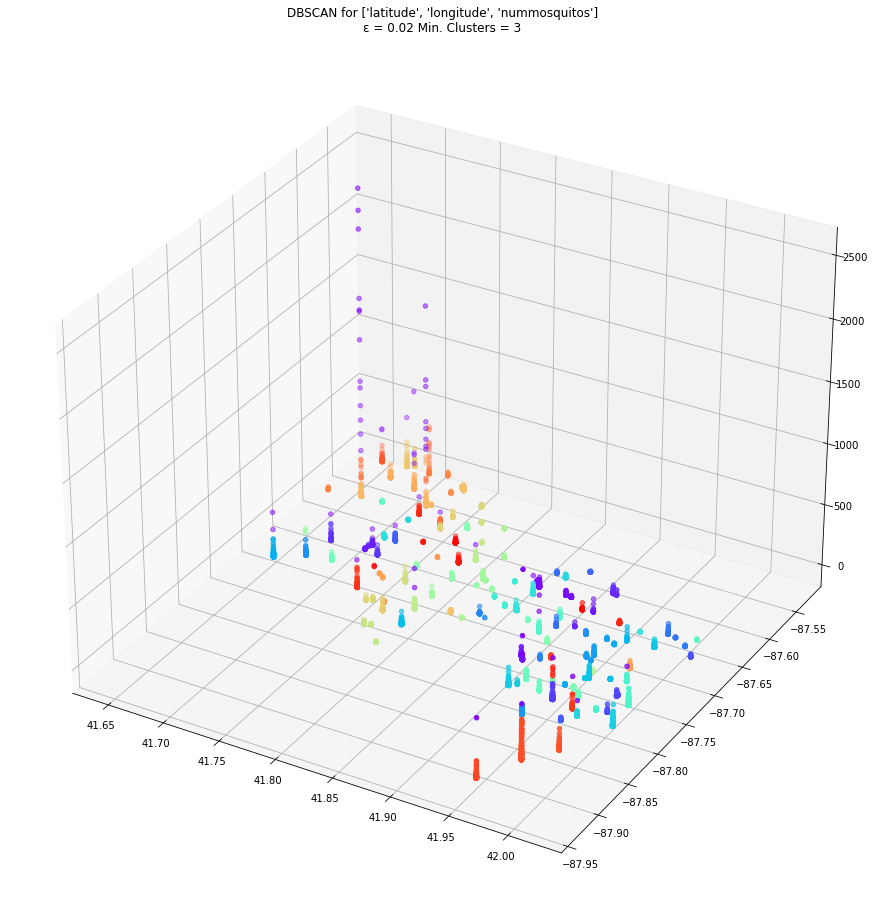

In [51]:
# Creating a 3D cluster based on number of mosquitoes captured
dbscan = dbscan(train2, ['latitude','longitude', 'nummosquitos'], eps = 0.02, min_samples=3)

Based on DBSCAN model, we are able to identify 122 clusters and 51 outliers. The silhouette score of more than 0.85 gives us confidence that these clusters are well defined. We shall proceed to analysis the clusters and outliers in capturing mosquitoes and identifying WNV cases.

In [52]:
cluster_group_sum = train2[['nummosquitos', 'wnvpresent','cluster']].groupby(['cluster']).sum()
cluster_group_sum.reset_index(inplace=True)
cluster_group_sum.sort_values(by='wnvpresent', inplace=True)

Total Number of Clusters with at least 1 WNV case: 95
Total Number of Clusters with more than 3 WNV cases (Hot Spots): 55
 


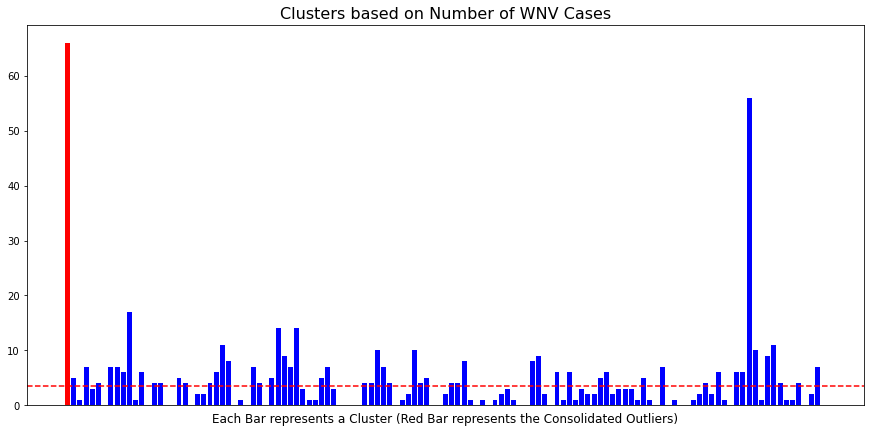

In [53]:
# Checking the number of WNV cases for each cluster including outliers labelled -1
print(f'Total Number of Clusters with at least 1 WNV case: {len(cluster_group_sum[cluster_group_sum["wnvpresent"]>0])-1}')
print(f'Total Number of Clusters with more than 3 WNV cases (Hot Spots): {len(cluster_group_sum[cluster_group_sum["wnvpresent"]>3])-1}')
print(' ')
plt.figure(figsize=(15,7))
colors = ["red" if i < 0 else "blue" for i in cluster_group_sum['cluster']]
plt.bar(cluster_group_sum['cluster'], cluster_group_sum['wnvpresent'], color=colors)
plt.title('Clusters based on Number of WNV Cases', fontsize=16)
plt.xticks([])
plt.xlabel('Each Bar represents a Cluster (Red Bar represents the Consolidated Outliers)', fontsize=12)
plt.axhline(y=3.5, color='r',linestyle = 'dashed');

In [54]:
# Filtering the cluster with the highest number of WNV cases
cluster_group_sum[cluster_group_sum['wnvpresent']>50]

cluster  nummosquitos  wnvpresent
110      109         11418          56
0         -1         34511          66

Of the 122 clusters (excluding the cluster of outliers), 95 clusters have at least more than 1 WNV case while 75 clusters have recurring WNV cases. Of note is cluster 109 which has the highest number of 56 WNV cases among the clusters. Interestingly, the 51 outliers collectively have the highest number of WNV cases. As a cut-off, we shall only consider those clusters with more than 3 WNV cases, which amounts to at least 1 WNV case on average annually, as hot spots. 

##### Examining Clusters

In [55]:
cluster_group_sum.head(2)

cluster  nummosquitos  wnvpresent
122      121            18           0
95        94            52           0

In [56]:
list_sign_cluster = list(cluster_group_sum[cluster_group_sum['wnvpresent']>3].index-1)
list_sign_cluster.remove(-1)
train2_cluster = train2[train2['cluster'].isin(list_sign_cluster)]

In [57]:
# Calculating the average count of samples per cluster
print(f'Average number of samples per cluster: {train2_cluster["cluster"].value_counts().mean():.2f}.')

Average number of samples per cluster: 96.82.


In [58]:
# Getting the max and min coords of each cluster
train_2_cluster_cood = pd.DataFrame()
train_2_cluster_maxlong = train2_cluster[['longitude', 'latitude','cluster']].groupby(['cluster'], sort=False)['longitude'].max()
train_2_cluster_minlong = train2_cluster[['longitude', 'latitude','cluster']].groupby(['cluster'], sort=False)['longitude'].min()
train_2_cluster_maxlat = train2_cluster[['longitude', 'latitude','cluster']].groupby(['cluster'], sort=False)['latitude'].max()
train_2_cluster_minlat = train2_cluster[['longitude', 'latitude','cluster']].groupby(['cluster'], sort=False)['latitude'].min()

In [59]:
train_2_cluster_cood['cluster'] = train_2_cluster_maxlong.index
train_2_cluster_cood['maxlong'] = list(train_2_cluster_maxlong)
train_2_cluster_cood['minlong'] = list(train_2_cluster_minlong)
train_2_cluster_cood['maxlat'] = list(train_2_cluster_maxlat)
train_2_cluster_cood['minlat'] = list(train_2_cluster_minlat)

In [60]:
train_2_cluster_cood['long_diff'] = train_2_cluster_cood['maxlong'] - train_2_cluster_cood['minlong']
train_2_cluster_cood['lat_diff'] = train_2_cluster_cood['maxlat'] - train_2_cluster_cood['minlat']

In [61]:
train_2_cluster_cood.head()

cluster    maxlong    minlong     maxlat     minlat  long_diff  lat_diff
0        0 -87.648860 -87.654224  41.867108  41.862292   0.005364  0.004816
1        2 -87.756155 -87.760886  41.907645  41.904194   0.004731  0.003451
2        4 -87.666014 -87.675088  41.720848  41.719059   0.009074  0.001789
3        6 -87.632085 -87.633590  41.925652  41.921965   0.001505  0.003687
4        7 -87.676709 -87.676709  41.688324  41.688324   0.000000  0.000000

Given that not every cluster has an area of impact (i.e. the coordinates of all the samples in the cluster are the same), we shall use the mean from the maximum and minimum of the latitude and longtitude respectively of the other clusters to compute the area of impact for these clusters. 

In [62]:
# Filtering out clusters with area of impact
train_2_cluster_diff = train_2_cluster_cood[train_2_cluster_cood['long_diff'] != 0]

In [63]:
# Calculating mean for longitude and latitude
long_diff_mean = train_2_cluster_diff['long_diff'].mean()
lat_diff_mean = train_2_cluster_diff['lat_diff'].mean()

In [64]:
# Filtering out clusters without area of impact
train_2_cluster_same = train_2_cluster_cood[train_2_cluster_cood['long_diff'] == 0]

In [65]:
# Using the mean to compute max, min for longitude and laitude of clusters with no area of impact
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
train_2_cluster_same['maxlong'] = (train_2_cluster_same['maxlong'] + (long_diff_mean/2))
train_2_cluster_same['minlong'] = (train_2_cluster_same['maxlong'] - (long_diff_mean/2))
train_2_cluster_same['maxlat'] = (train_2_cluster_same['maxlat'] + (lat_diff_mean/2))
train_2_cluster_same['minlat'] = (train_2_cluster_same['maxlat'] - (lat_diff_mean/2))

In [66]:
# Drop the diff columns as they are no longer necessary
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
train_2_cluster_same.drop(columns=['long_diff','lat_diff'], inplace =True)
train_2_cluster_diff.drop(columns=['long_diff','lat_diff'], inplace =True)
cluster_final = pd.concat([train_2_cluster_same,train_2_cluster_diff], ignore_index=True)

##### Examining Outliers

In [67]:
# Filter out the outliers
outliers = train2.query("cluster == -1")

In [68]:
outliers.head(3)

date                                    address  \
536 2007-07-19  3700 118th Street, Chicago, IL 60617, USA   
569 2007-07-25        South Doty Avenue, Chicago, IL, USA   
570 2007-07-25        South Doty Avenue, Chicago, IL, USA   

                    species  block       street  trap  \
536  CULEX PIPIENS/RESTUANS     37   E 118TH ST  T212   
569           CULEX PIPIENS     12   S DOTY AVE  T115   
570  CULEX PIPIENS/RESTUANS     12   S DOTY AVE  T115   

            addressnumberandstreet   latitude  longitude  addressaccuracy  \
536  3700  E 118TH ST, Chicago, IL  41.680946 -87.535198                8   
569  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   
570  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   

     nummosquitos  wnvpresent  year  month  weekofyear  cluster  
536           418           0  2007      7          29       -1  
569          2356           3  2007      7          30       -1  
570           644           2  2007      7          30       -1

Interestingly, some of the outliers belong to the same location. The reason why they are not clustered together is due to difference in terms of number of mosquitoes captured (recall that the DBSCAN consists of three dimensions - longitude, latitude and the number of mosquitoes captured). Hence, there is a need to combine those outliers with the same latitude and longitude.

In [69]:
outliers_sum = outliers[['nummosquitos', 'wnvpresent','latitude', 'longitude']].groupby(['latitude', 'longitude']).sum()
outliers_sum = pd.DataFrame(outliers_sum.to_records())

In [70]:
# Showing the number of actual outliers
print(f'Actual Number of Outliers: {len(outliers_sum)}')

Actual Number of Outliers: 22


Total Number of Outlier Clusters with at least 1 WNV case: 8
Total Number of Outlier Clusters with more than 3 WNV cases (Hot Spots): 4
 


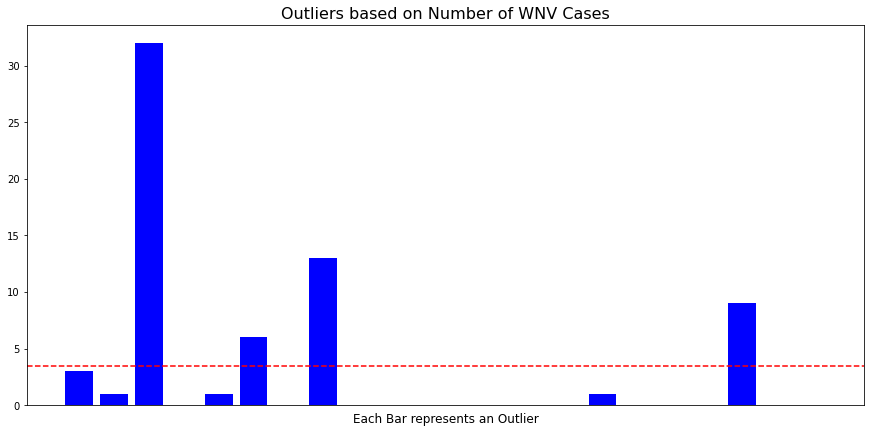

In [71]:
print(f'Total Number of Outlier Clusters with at least 1 WNV case: {len(outliers_sum[outliers_sum["wnvpresent"]>0])}')
print(f'Total Number of Outlier Clusters with more than 3 WNV cases (Hot Spots): {len(outliers_sum[outliers_sum["wnvpresent"]>3])}')
print(' ')
plt.figure(figsize=(15,7))
plt.bar(outliers_sum['wnvpresent'].index, outliers_sum['wnvpresent'], color=colors)
plt.title('Outliers based on Number of WNV Cases', fontsize=16)
plt.xticks([])
plt.xlabel('Each Bar represents an Outlier', fontsize=12)
plt.axhline(y=3.5, color='r',linestyle = 'dashed');

In [72]:
outliers = outliers.query("wnvpresent > 3")

In [73]:
# Providing names for outliers (for 500 onwards)
outliers['cluster'] = [ x+500 for x in range(len(outliers))]

In [74]:
# Taking reference from clusters to create clusters for these outliers
outliers['maxlong'] = (outliers['longitude'] + (long_diff_mean/2))
outliers['minlong'] = (outliers['longitude'] - (long_diff_mean/2))
outliers['maxlat'] = (outliers['latitude'] + (lat_diff_mean/2))
outliers['minlat'] = (outliers['latitude'] - (lat_diff_mean/2))

In [75]:
outliers.drop(columns=['latitude','longitude','nummosquitos','wnvpresent'])
outliers = outliers[['cluster', 'maxlong', 'minlong', 'maxlat', 'minlat']]       

##### Combining Coordinates from Clusters and Outliers

In [76]:
# Identifying the hotspots with more than 3 WNV cases
wnv_hotspots = pd.concat([cluster_final,outliers], ignore_index=True)

In [77]:
wnv_hotspots.head(2)

cluster    maxlong    minlong     maxlat     minlat
0        7 -87.674579 -87.676709  41.690326  41.688324
1        8 -87.675382 -87.677512  41.733924  41.731922

In [78]:
# Feature engineering for train dataset based on cluster density
train_hot_spots = []
train_hot_spots_name = []
for index, i in train.iterrows():
    for index, j in wnv_hotspots.iterrows():
        if i['latitude'] <= j['maxlat'] and i['longitude'] <= j['maxlong'] and i['latitude'] >= j['minlat'] and i['longitude'] >= j['minlong']:
            train_hot_spots.append(1)
            train_hot_spots_name.append(j['cluster'])
            break
    else: 
        train_hot_spots.append(0)
        train_hot_spots_name.append(1000)

In [79]:
# Create a column for hot spot indication
train['hot_spots'] = train_hot_spots
train['hot_spots_name'] = train_hot_spots_name

#### Observation

With the feature engineering of the `'hot_spots'` column, we shall further utilise this information in the following areas:-
1. **Measurement of the Effectiveness of Spraying** 

Given the identified hot spot locations, we are able to measure the effectiveness by spraying if any sprayed coordinates fall within the areas of hot spots. This will be further elaborated under section 6.5.

2. **Calculating the Area of each Hot Spot** 

The maximum and mininum coordinates from each hot spot allows us to calculate their mean area. With the information, we are able to provide a more targeted approach in identifying the exact locations in need of spraying and to work out the cost.

### 5.2 Weather Dataset

#### Create: Humidity Column

As mosquitoes tend to grow in humid weather, relative humidity has been featured-engineered with reference to the [humidity calculator](https://www.calcunation.com/calculator/humidity-calculator.php).

In [80]:
weather['relativehumidity'] = 100 * (np.exp((17.67 * ((weather['dewpoint'] - 32) * (5/9))) / 
                                           (243.5 + ((weather['dewpoint'] - 32) * (5/9)))) 
                                    /
                                    np.exp((17.67 * ((weather['tavg'] - 32) * (5/9))) /
                                           (243.5 + ((weather['tavg'] - 32) * (5/9)))))

#### Create: Year, Month, Week of Year Columns

This breaks down the date into more features.

In [81]:
weather['year'] = weather['date'].apply(lambda x:x.year)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['weekofyear'] = weather['date'].apply(lambda x:x.weekofyear)

### 5.3 Spray Dataset

#### Create: Year, Month, Week of Year Columns

In [82]:
spray['year'] = spray['date'].apply(lambda x:x.year)
spray['month'] = spray['date'].apply(lambda x:x.month)
spray['weekofyear'] = spray['date'].apply(lambda x:x.weekofyear)

In summary, the following features have been created for each dataset:-
* `train`: Created `'year'`, `'month'`, `'weekofyear'` and `'hot_spots'` columns. Total: 4
* `weather`: Created `'year'`, `'month'`, `'weekofyear'` and `'relativehumidity'` columns. Total: 4
* `spray`: Created `'year'`, `'month'` and `'weekofyear'` columns. Total: 3

Note: Any changes applied to `train` dataset will be applied to `test` dataset subsequently.

## 6. Exploratory Data Analysis (EDA)

### 6.1 Train Dataset

As a recap, we shall be using the `'train2'` dataset for EDA as the aggregation of `'nummosquitos'` and `'wnvpresent'` is more accurate for analysis.

In [83]:
# recapping the train dataset
train2.head(2)

date                                      address  \
0 2007-05-29  1100 Roosevelt Road, Chicago, IL 60608, USA   
1 2007-05-29  1100 Roosevelt Road, Chicago, IL 60608, USA   

                  species  block        street  trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   

           addressnumberandstreet   latitude  longitude  addressaccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   

   nummosquitos  wnvpresent  year  month  weekofyear  cluster  
0             1           0  2007      5          22        0  
1             2           0  2007      5          22        0

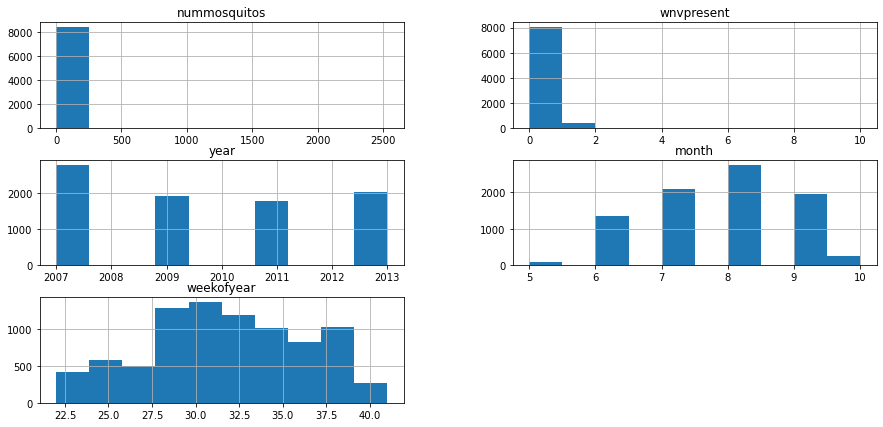

In [84]:
# Checking the distribution for selective numerical features
train2[['nummosquitos', 'wnvpresent', 'year', 'month', 'weekofyear']].hist(figsize=(15,7));

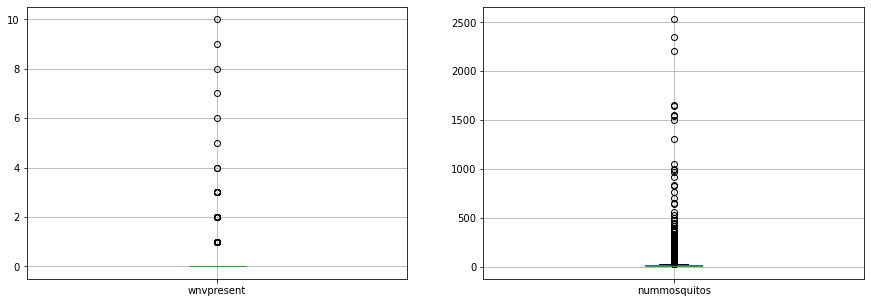

In [85]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 1]})
train2.boxplot(column='wnvpresent', ax = ax[0])
train2.boxplot(column='nummosquitos', ax = ax[1]);

#### Observation

1. Based on the distribution of `'year'` column, there is a general decrease in mosquitoes captured since each row represents at least one mosquito captured from 2007 to 2013. 
2. Based on the distribution of `'month'` column, the month with the highest mosquitoes captured is August followed by July. June and September are also relatively high in numbers. The distribution of `'weekofyear'` column shares similar insights with week 29 to 32 (July to August) of the year has the highest numbers of mosquitoes captured. 
3. The `'wnvpresent'` column, as mentioned, is imbalance as majority of the data did not detect the presence of WNV from mosquitoes captured. The highest number of WNV cases is 10. It is worth noting that the number of WNV cases detected does not represents the number of mosquitoes captured has WNV. Each indication of WNV case indicates an instance of WNV detected from a group of mosquitoes (up to 50) captured. 
4. Most number of mosquitoes captured for a trap is below 250. The highest number is more than 2500.

Correlation between Number of Mosquitoes Captured and WNV Detected: 0.49
 


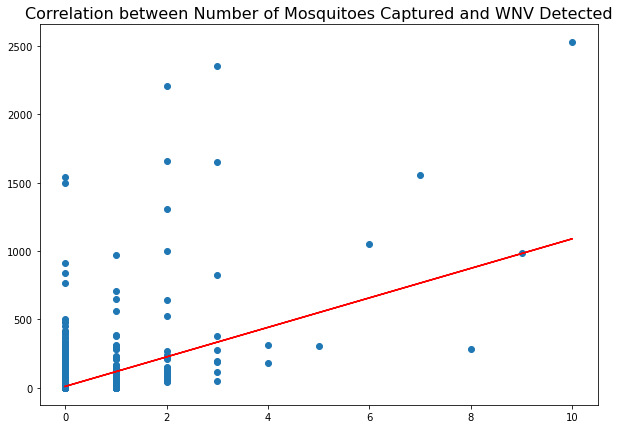

In [86]:
plt.figure(figsize=(10,7))
print(f"Correlation between Number of Mosquitoes Captured and WNV Detected: {train2['wnvpresent'].corr(train2['nummosquitos']):.2f}")
print(' ')
plt.scatter(train2['wnvpresent'], train2['nummosquitos'])
m, b = np.polyfit(train2['wnvpresent'], train2['nummosquitos'], 1)
plt.plot(train2['wnvpresent'], m*train2['wnvpresent']+b, color='red')
plt.title('Correlation between Number of Mosquitoes Captured and WNV Detected', fontsize=16);

CULEX PIPIENS/RESTUANS    3826
CULEX RESTUANS            2393
CULEX PIPIENS             1950
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64
 


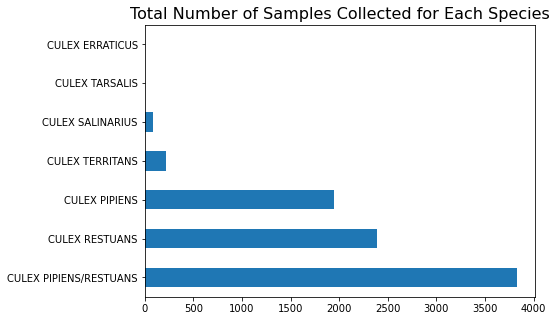

In [87]:
print(train2['species'].value_counts())
print(' ')
train2['species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('Total Number of Samples Collected for Each Species', fontsize=16);

                        nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44488         240
CULEX PIPIENS/RESTUANS         65841         261
CULEX RESTUANS                 23326          49
CULEX SALINARIUS                 144           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  508           0
 


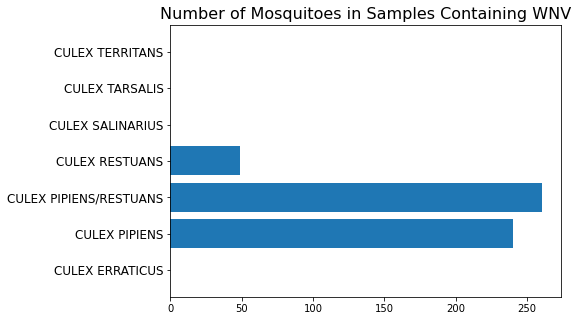

In [88]:
mos_wnv = train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum()
print(mos_wnv)
print(' ')
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(7,5))
plt.barh(mos_wnv['species'], mos_wnv['wnvpresent'])
plt.title('Number of Mosquitoes in Samples Containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

#### Observation

1. The correlation between number of mosquitoes captured and WNV detected is relatively strong at 0.49. This means that working out the number of mosquitoes captured is a relative good predictor to detect WNV.
2. Of the 7 types of mosquitoes captured, the culex restuans, culex pipiens and culex pipiens/restuans are the most common, which are also the only species with WNV detected.

<Figure size 1080x360 with 0 Axes>

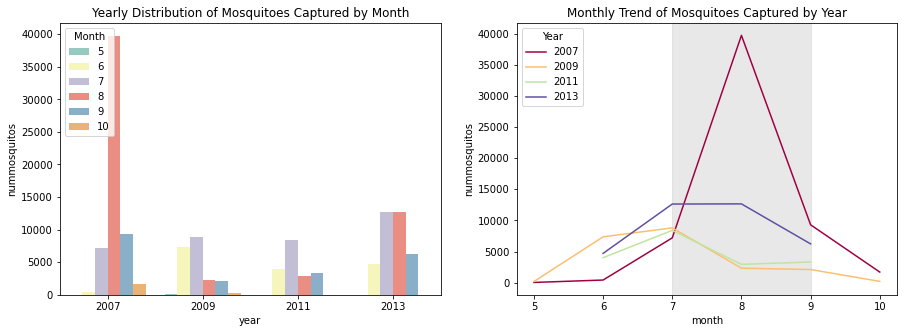

In [89]:
plt.figure(figsize=(15,5))
plt.show()

fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [2, 2]})

wnv2 = train2[['nummosquitos', 'month', 'year']].groupby(by=['month','year']).sum()
wnv2.reset_index(inplace=True)

sns.barplot(x = wnv2['year'],y = 'nummosquitos', data = wnv2, hue = 'month', palette = 'Set3', ci = None, ax = ax[0])
ax[0].set_title('Yearly Distribution of Mosquitoes Captured by Month')
ax[0].legend(loc='upper left', title ='Month');

wnv1 = train2[['nummosquitos', 'month', 'year']].groupby(by=['month','year']).sum()
wnv1.reset_index(inplace=True)

sns.lineplot(x = wnv1['month'],y = 'nummosquitos', data = wnv1, hue = 'year', ci = None, palette = 'Spectral', ax = ax[1])
ax[1].set_title('Monthly Trend of Mosquitoes Captured by Year')
ax[1].axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
ax[1].legend(loc='upper left', title ='Year');

<Figure size 1080x360 with 0 Axes>

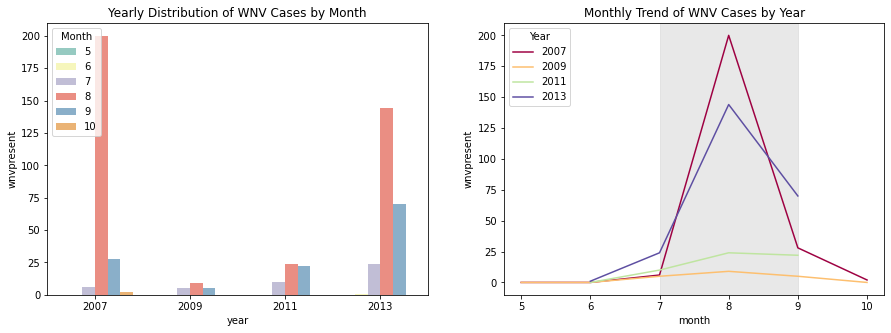

In [90]:
plt.figure(figsize=(15,5))
plt.show()

fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [2, 2]})

wnv2 = train2[['wnvpresent', 'month', 'year']].groupby(by=['month','year']).sum()
wnv2.reset_index(inplace=True)

sns.barplot(x = wnv2['year'],y = 'wnvpresent', data = wnv2, hue = 'month', palette = 'Set3', ci = None, ax = ax[0])
ax[0].set_title('Yearly Distribution of WNV Cases by Month')
ax[0].legend(loc='upper left', title ='Month');

wnv1 = train2[['wnvpresent', 'month', 'year']].groupby(by=['month','year']).sum()
wnv1.reset_index(inplace=True)

sns.lineplot(x = wnv1['month'],y = 'wnvpresent', data = wnv1, hue = 'year', ci = None, palette = 'Spectral', ax = ax[1])
ax[1].set_title('Monthly Trend of WNV Cases by Year')
ax[1].axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
ax[1].legend(loc='upper left', title ='Year');

#### Observation 

1. There was a spike in both numbers of mosquitoes captured and WNV cases detected from July to August. The following EDA on weather dataset will pay special attention to these months.
2. Year 2007 and 2013 specfically saw an increase number of WNV cases detected.

### 6.2 Weather Dataset

In [91]:
weather.head(2)

date  tmax  tmin  tavg  dewpoint  preciptotal  stnpressure  sealevel  \
0 2007-05-10  83.5  51.0  67.5      51.0          0.0        29.14    29.820   
1 2007-05-11  59.5  42.5  51.5      42.0          0.0        29.41    30.085   

   resultspeed  resultdir  avgspeed  relativehumidity  year  month  weekofyear  
0         2.20       26.0       9.4         55.444498  2007      5          19  
1        13.15        3.0      13.4         69.872482  2007      5          19

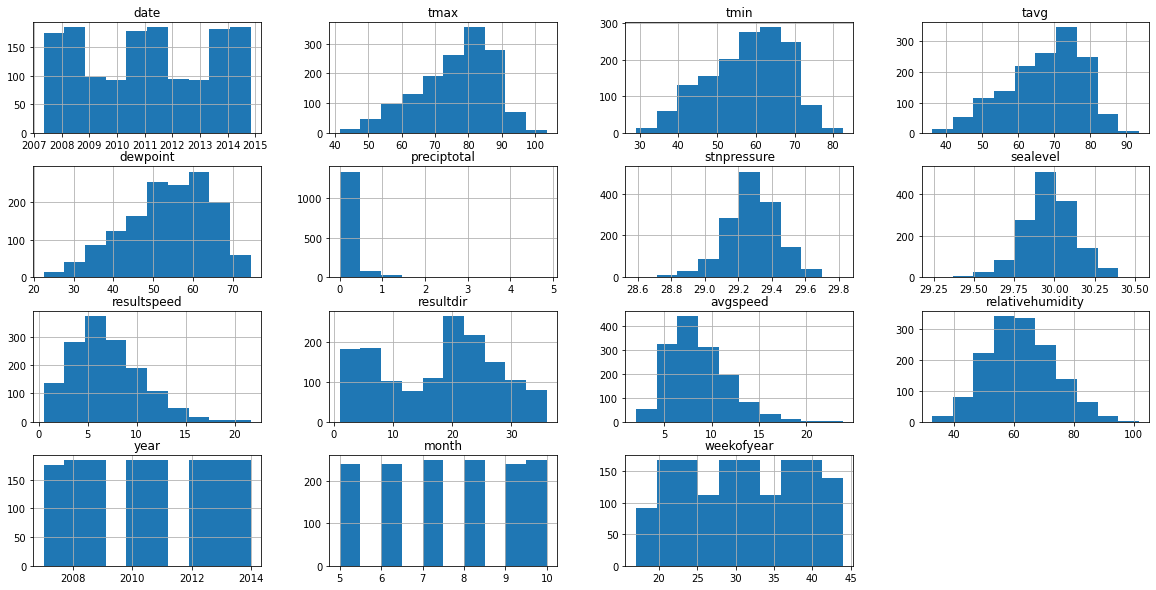

In [92]:
# Distribution of numerical variables
weather.hist(figsize=(20,10));

The histograms above show the distribution of each feature in the weather dataset. 

Based on the previous EDA on the train dataset, we observed that the months from July to September tend to have a spike in the number of mosquitoes captured and WNV identified. Hence, it is of interest to look out for features with similar pattern. Below are the selected five features displayed.

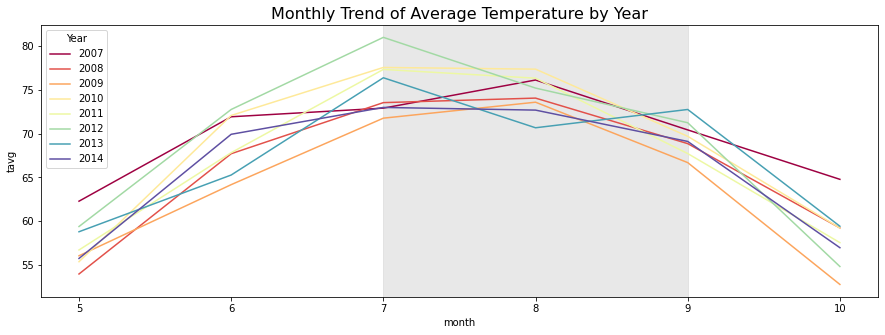

In [93]:
plt.figure(figsize=(15,5))
wnv = weather[['date','tavg','year','month']]
sns.lineplot(x = wnv['month'],y = 'tavg', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
plt.legend(loc='upper left', title ='Year')
plt.title('Monthly Trend of Average Temperature by Year', fontsize=16);

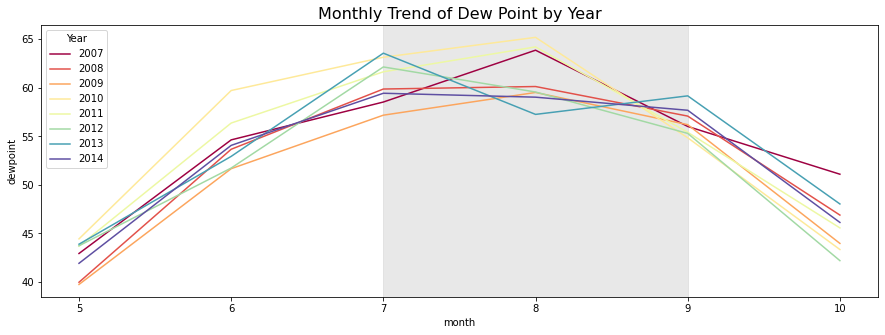

In [94]:
plt.figure(figsize=(15,5))
wnv = weather[['date','dewpoint','year','month']]
sns.lineplot(x = wnv['month'],y = 'dewpoint', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
plt.legend(loc='upper left', title ='Year')
plt.title('Monthly Trend of Dew Point by Year', fontsize=16);

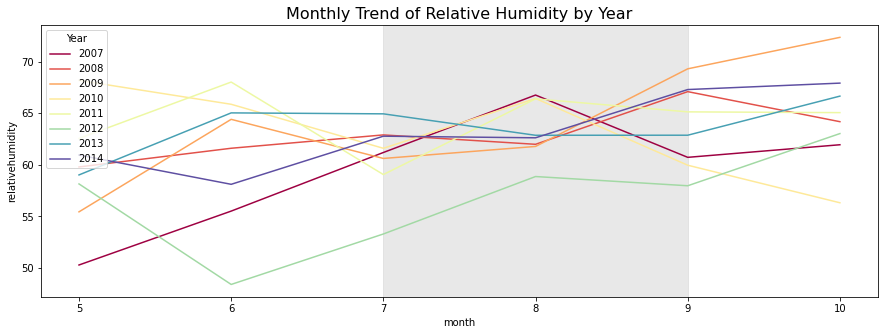

In [95]:
plt.figure(figsize=(15,5))
wnv = weather[['date','relativehumidity','year','month']]
sns.lineplot(x = wnv['month'],y = 'relativehumidity', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
plt.legend(loc='upper left', title ='Year')
plt.title('Monthly Trend of Relative Humidity by Year', fontsize=16);

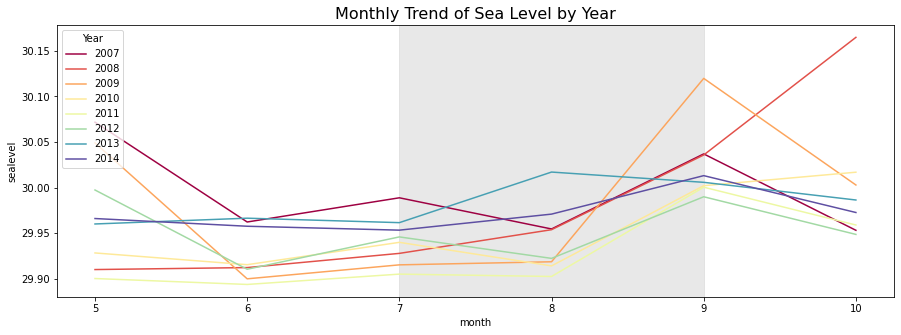

In [96]:
plt.figure(figsize=(15,5))
wnv = weather[['date','sealevel','year','month']]
sns.lineplot(x = wnv['month'],y = 'sealevel', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.axvspan(xmin=7, xmax= 9, color='lightgrey', alpha =0.5)
plt.legend(loc='upper left', title ='Year')
plt.title('Monthly Trend of Sea Level by Year', fontsize=16);

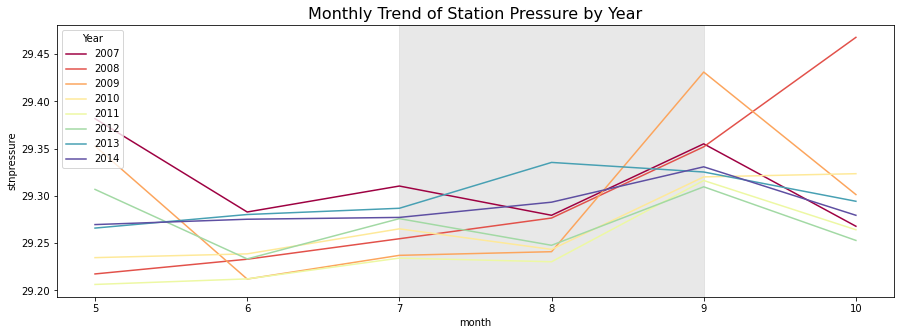

In [97]:
plt.figure(figsize=(15,5))
wnv = weather[['date','stnpressure','year','month']]
sns.lineplot(x = wnv['month'],y = 'stnpressure', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.axvspan(xmin=7, xmax=9, color='lightgrey', alpha =0.5)
plt.legend(loc='upper left', title ='Year')
plt.title('Monthly Trend of Station Pressure by Year', fontsize=16);

#### Observation

1. Of the five selected features, all were showed to be on downward trend apart from the monthly trend of average temperature and dew point from July to September, while the opposite is true for the monthly trend of sea level and station pressure. 
2. Relative humidity was shown to be higher in the 2nd half of each year.
3. Nevertheless, it remains to be seen if any of these features are significant in predicting the presence of WNV virus.

### 6.3 Spray Dataset

In [98]:
spray.head(2)

date   latitude  longitude  year  month  weekofyear
95 2011-09-07  41.981433 -87.787777  2011      9          36
96 2011-09-07  41.980998 -87.787778  2011      9          36

2013    0.888795
2011    0.111205
Name: year, dtype: float64
 


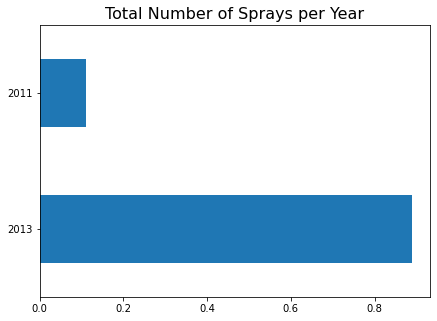

In [99]:
print(spray['year'].value_counts(normalize=True))
print(' ')
spray['year'].value_counts(normalize=True).plot(kind='barh', figsize=(7,5))
plt.title('Total Number of Sprays per Year', fontsize=16);

2013    12572
2011     1573
Name: year, dtype: int64
 


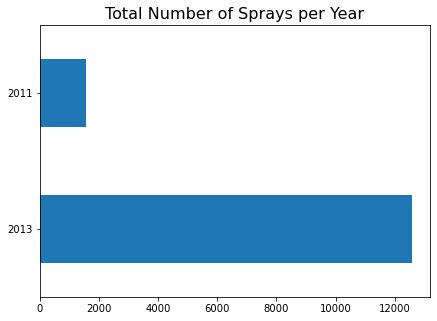

In [100]:
print(spray['year'].value_counts())
print(' ')
spray['year'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('Total Number of Sprays per Year', fontsize=16);

### 6.4 Map Visualisation of Spray Dataset with Train Dataset

We shall now create a map visualisation of the sprayed area, clusters of mosquitoes and clusters of WNV cases detected for each year from the train dataset.

In [101]:
train_2007 = split_year(train, 2007)
train_2009 = split_year(train, 2009)
train_2011 = split_year(train, 2011)
train_2013 = split_year(train, 2013)
spray_2011 = split_year(spray, 2011)
spray_2013 = split_year(spray, 2013)

In [102]:
mosquito_2009 = mosquito_areas_wnv_df(train_2009)
mosquito_2007 = mosquito_areas_wnv_df(train_2007)
mosquito_2011 = mosquito_areas_wnv_df(train_2011)
mosquito_2013 = mosquito_areas_wnv_df(train_2013)

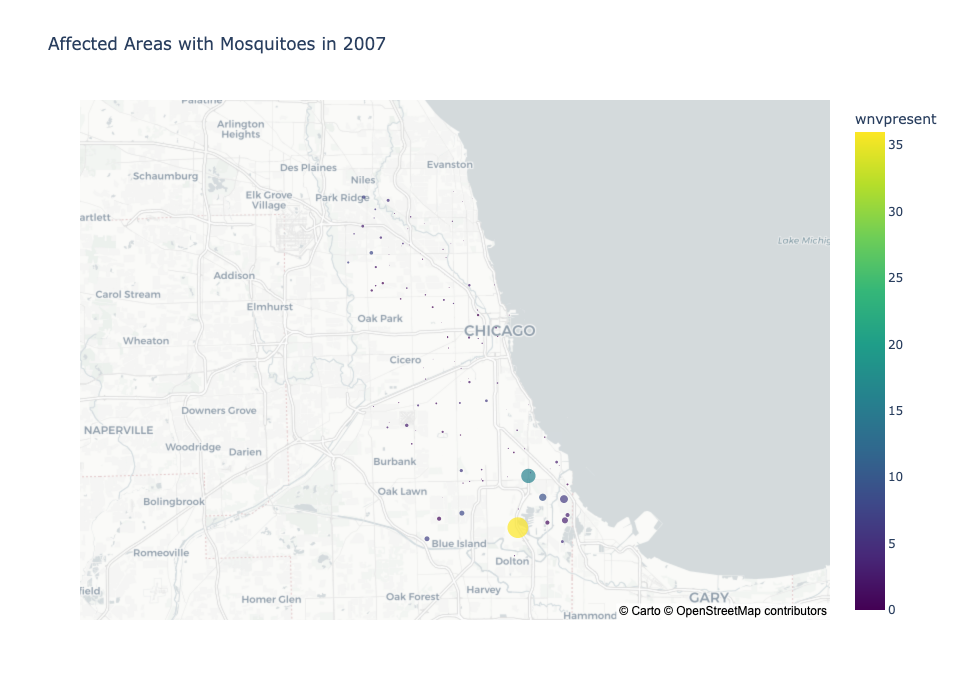

In [103]:
# Map for 2007
fig = px.scatter_mapbox(data_frame=mosquito_2007, lat='latitude', lon ='longitude', 
                         color = 'wnvpresent', size = 'nummosquitos', 
                         color_continuous_scale='viridis',
                        hover_data = ['nummosquitos', 'wnvpresent'],
                        mapbox_style='carto-positron', 
                        size_max=15, zoom = 9, width=500, height=700,
                        title='Affected Areas with Mosquitoes in 2007')
fig.show();

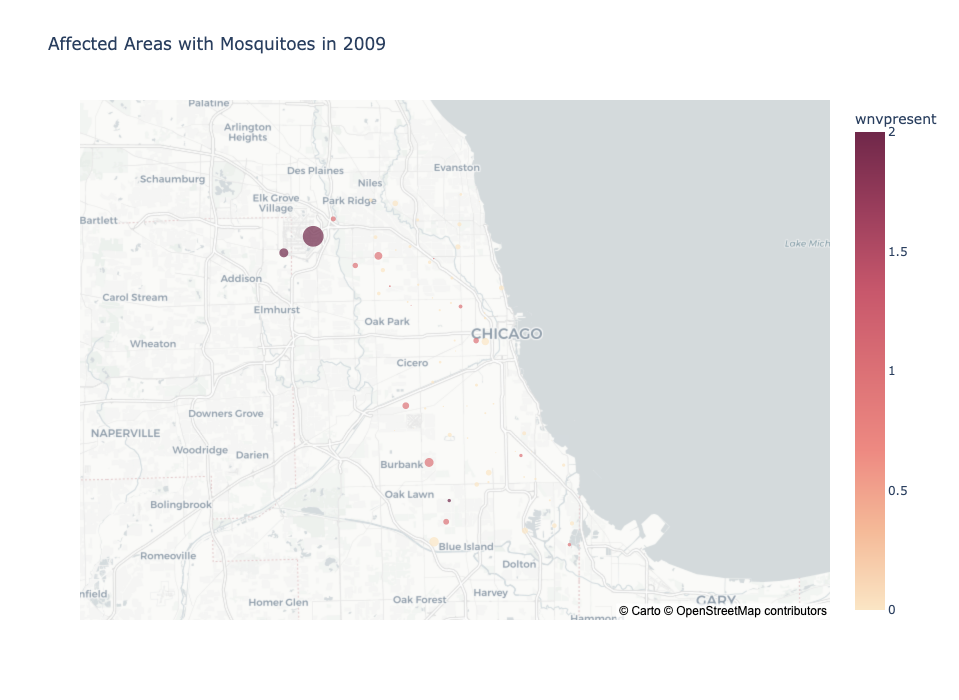

In [104]:
# Map for 2009 
fig2 = px.scatter_mapbox(data_frame=mosquito_2009, lat='latitude', lon ='longitude', 
                          color = 'wnvpresent', size = 'nummosquitos', 
                          color_continuous_scale='burgyl',
                          hover_data = ['nummosquitos', 'wnvpresent'],
                          mapbox_style='carto-positron',
                          size_max=15, zoom = 9, width=500, height=700,
                          title='Affected Areas with Mosquitoes in 2009')
fig2.show();

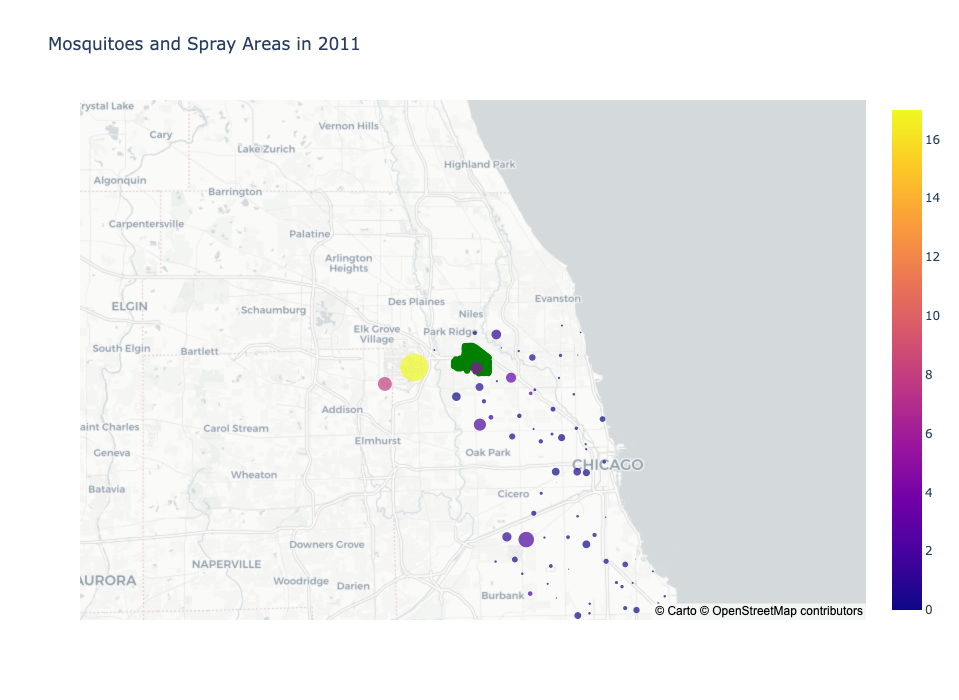

In [105]:
# Map for 2011 
fig = px.scatter_mapbox(spray_2011, lat='latitude', lon ='longitude',
                        mapbox_style='carto-positron', 
                        size_max=15, zoom = 9, width=500, height=700,
                        title='Mosquitoes and Spray Areas in 2011',
                        color_discrete_sequence=['green']
                       )
fig2 = px.scatter_mapbox(data_frame=mosquito_2011, lat='latitude', lon ='longitude', 
                         color = 'wnvpresent', size = 'nummosquitos', 
                         color_continuous_scale='burgyl',
                        hover_data = ['nummosquitos', 'wnvpresent'],
                        )
fig.add_trace(fig2.data[0],)
fig.show();

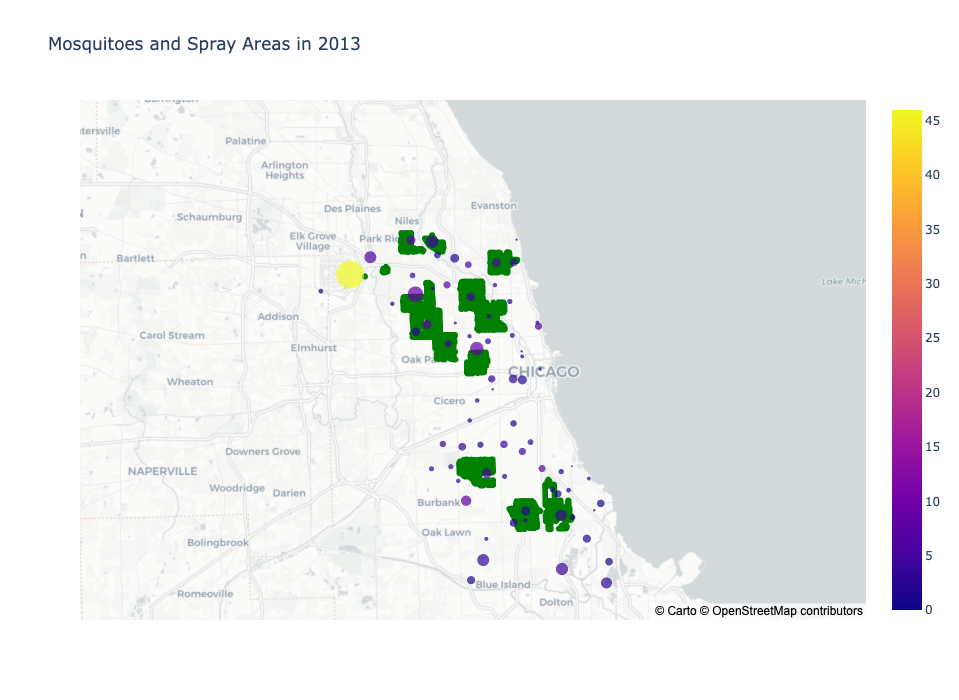

In [106]:
# Map for 2013
fig = px.scatter_mapbox(spray_2013, lat='latitude', lon ='longitude',
                        mapbox_style='carto-positron', 
                        size_max=15, zoom = 9, width=500, height=700,
                        title='Mosquitoes and Spray Areas in 2013',
                        color_discrete_sequence=['green']
                       )

fig2 = px.scatter_mapbox(data_frame=mosquito_2013, lat='latitude', lon ='longitude', 
                         color = 'wnvpresent', size = 'nummosquitos', 
                         color_continuous_scale='burgyl',
                        hover_data = ['nummosquitos', 'wnvpresent'],
                        )
fig.add_trace(fig2.data[0],)
fig.show();

#### Observation
1. As indicated, sprays were only administered in 2011 and 2013.
2. Year 2009 saw the least amount of WNV cases detected.
3. The spray area in 2011 was only able to cover one cluster while leaving the others unaddressed.
4. Despite more efforts in spraying, there was no visible improvement in 2013.

### 6.5 Effectiveness of Spray 

Given that we have managed to locate the areas of clusters, we shall first proceed to locate those clusters that had been sprayed and next measure its effectiveness by identifying the time taken for a WNV case to occur.

In [107]:
# Dividing train dataset according to year
train_2011 = train.query("year == 2011")
train_2013 = train.query("year == 2013")

In [108]:
# Creating a list to indicate cluster sprayed and names of clusters
cluster_sprayed = []
cluster_sprayed_name = []
for index, i in spray.iterrows():
    for index, j in wnv_hotspots.iterrows():
        if i['latitude'] <= j['maxlat'] and i['longitude'] <= j['maxlong'] and i['latitude'] >= j['minlat'] and i['longitude'] >= j['minlong']:
            cluster_sprayed.append(1)
            cluster_sprayed_name.append(j['cluster'])
            break
    else: 
        cluster_sprayed.append(0)
        cluster_sprayed_name.append(1000)

In [109]:
# Creating the respective columns
spray['cluster_sprayed']=cluster_sprayed
spray['cluster_sprayed_name']=cluster_sprayed_name

0    13918
1      227
Name: cluster_sprayed, dtype: int64
 


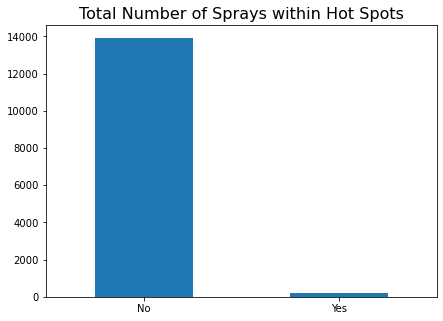

In [110]:
# No. of spray coordinates within the hot spots
print(spray['cluster_sprayed'].value_counts())
print(' ')
spray['cluster_sprayed'].value_counts().plot(kind='bar', figsize=(7,5))
plt.title('Total Number of Sprays within Hot Spots', fontsize=16)
plt.xticks(ticks = [0, 1],labels=['No','Yes'], rotation = 0);

0    0.983952
1    0.016048
Name: cluster_sprayed, dtype: float64
 


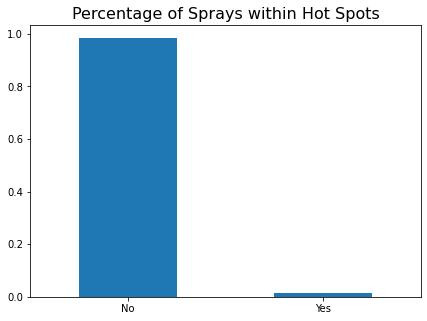

In [111]:
# % of spray coordinates within the hot spots
print(spray['cluster_sprayed'].value_counts(normalize=True))
print(' ')
spray['cluster_sprayed'].value_counts(normalize=True).plot(kind='bar', figsize=(7,5))
plt.title('Percentage of Sprays within Hot Spots', fontsize=16)
plt.xticks(ticks = [0, 1],labels=['No','Yes'], rotation = 0);

The spraying efforts in 2011 and 2013 had a extremely low hit rate of 1.6% in tackling those hot spots (more than one WNV case on average per year) identified.

In [112]:
# Filtering out those sprays that are located within hot spots
spray = spray[spray['cluster_sprayed']==1]

2013    210
2011     17
Name: year, dtype: int64
 


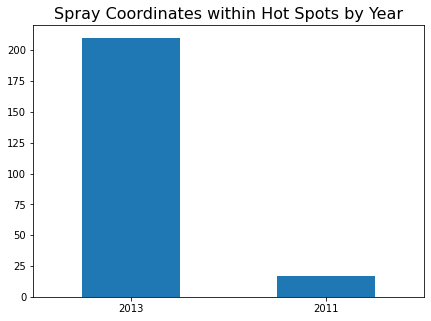

In [113]:
# Spray coordinates within hot spots by year
print(spray['year'].value_counts())
print(' ')
spray['year'].value_counts().plot(kind='bar', figsize=(7,5))
plt.title('Spray Coordinates within Hot Spots by Year', fontsize=16)
plt.xticks(rotation = 0);

2013    0.92511
2011    0.07489
Name: year, dtype: float64
 


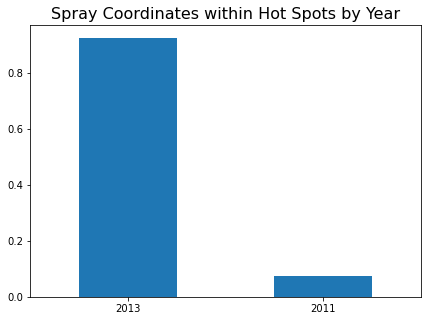

In [114]:
# % of spray coordinates within hot spots by year
print(spray['year'].value_counts(normalize=True))
print(' ')
spray['year'].value_counts(normalize=True).plot(kind='bar', figsize=(7,5))
plt.title('Spray Coordinates within Hot Spots by Year', fontsize=16)
plt.xticks(rotation = 0);

#### Spray Coordinates in Hot Spots for 2011

In [115]:
# Filtering out 2011
spray_2011 = spray[spray['year']==2011]

In [116]:
# Filtering out those sprayed clusters in 2011 and with WNV cases 
train_2011 = train_2011[train_2011['wnvpresent']==1].sort_values(by='hot_spots_name')
train_2011 = train_2011[train_2011['hot_spots']==1]
train_2011 = train_2011[train_2011['hot_spots_name'].isin(cluster_sprayed_name)]

In [117]:
# There was only one spray date in 2011 for the hot spots
spray_2011['date'].value_counts()

2011-09-07    17
Name: date, dtype: int64

In [118]:
# Given that there was only one spray date, we will filter out those train data beyond the date
train_2011 = train_2011[train_2011['date']>'20110907']

In [119]:
# Calculating the difference in days after spraying the clusters
train_2011['diff'] = train_2011['date'] - datetime.strptime("2011/09/07", "%Y/%m/%d")

In [120]:
train_2011.head(2)

date                 species            addressnumberandstreet  \
7807 2011-09-12  CULEX PIPIENS/RESTUANS  1300  N LARAMIE AVE, Chicago, IL   
7722 2011-09-12  CULEX PIPIENS/RESTUANS  3700  N KEDVALE AVE, Chicago, IL   

       latitude  longitude  nummosquitos  wnvpresent  year  month  weekofyear  \
7807  41.904194 -87.756155            24           1  2011      9          37   
7722  41.948167 -87.730698             6           1  2011      9          37   

      hot_spots  hot_spots_name   diff  
7807          1             2.0 5 days  
7722          1            25.0 5 days

In [121]:
# Keeping only the earliest date after spraying for each sprayed clusters
train_2011 = train_2011.loc[train_2011.groupby('hot_spots_name').date.idxmin()].reset_index(drop=True)

In [122]:
# Creating a df to store the data
train_2011['diff'] = train_2011['diff'].astype(str)
train_2011['diff'] = train_2011['diff'].str.replace(" days","")
train_2011['diff'] = train_2011['diff'].astype(int)

In [123]:
# There was only one spray date in 2011 for the hot spots
spray_2011['date'].value_counts()

2011-09-07    17
Name: date, dtype: int64

In [124]:
effect_sprayed_cluster_2011 = train_2011[['hot_spots_name', 'diff']]

In [125]:
effect_sprayed_cluster_2011.head(2)

hot_spots_name  diff
0             2.0     5
1            25.0     5

#### Spray Coordinates in Hot Spots for 2013

In [126]:
# Filtering out 2013
spray_2013 = spray[spray['year']==2013]

In [127]:
# Filtering out those sprayed clusters in 2011 and with WNV cases 
train_2013 = train_2013[train_2013['wnvpresent']==1].sort_values(by='hot_spots_name')
train_2013 = train_2013[train_2013['hot_spots']==1]
train_2013 = train_2013[train_2013['hot_spots_name'].isin(cluster_sprayed_name)]

In [128]:
# Many spray dates for 2013
spray_2013['date'].value_counts()

2013-07-25    68
2013-08-15    56
2013-09-05    39
2013-07-17    25
2013-08-22    11
2013-08-29     7
2013-08-08     4
Name: date, dtype: int64

In [129]:
# Mapping dates sprayed into a column
dictionary = dict(zip(spray_2013['cluster_sprayed_name'], spray_2013['date']))
train_2013['date_sprayed'] = train_2013['hot_spots_name'].map(dictionary)

In [130]:
# Gettting the difference in days from date_sprayed to date
train_2013['diff'] = train_2013['date'] - train_2013['date_sprayed']
train_2013['diff'] = train_2013['diff'].astype(str)
train_2013 = train_2013[train_2013['diff']!='NaT']
train_2013['diff'] = train_2013['diff'].str.replace(" days","")
train_2013['diff'] = train_2013['diff'].astype(int)
train_2013 = train_2013[train_2013['diff']>0]

In [131]:
train_2013.head()

date                 species  \
9887  2013-08-29  CULEX PIPIENS/RESTUANS   
10194 2013-09-12           CULEX PIPIENS   
10149 2013-09-06  CULEX PIPIENS/RESTUANS   
9861  2013-08-22           CULEX PIPIENS   
10052 2013-09-06           CULEX PIPIENS   

                      addressnumberandstreet   latitude  longitude  \
9887       8900  S CARPENTER ST, Chicago, IL  41.732984 -87.649642   
10194     2800  N FRANCISCO AVE, Chicago, IL  41.932094 -87.700117   
10149   3900  N SPRINGFIELD AVE, Chicago, IL  41.951866 -87.725057   
9861    3900  N SPRINGFIELD AVE, Chicago, IL  41.951866 -87.725057   
10052  7000   W ARMITAGE AVENUE, Chicago, IL  41.916265 -87.800515   

       nummosquitos  wnvpresent  year  month  weekofyear  hot_spots  \
9887             19           1  2013      8          35          1   
10194            13           1  2013      9          37          1   
10149            16           1  2013      9          36          1   
9861             15           1  2013      8          34          1   
10052            13           1  2013      9          36          1   

       hot_spots_name date_sprayed  diff  
9887             14.0   2013-07-17    43  
10194            22.0   2013-08-08    35  
10149            25.0   2013-07-25    43  
9861             25.0   2013-07-25    28  
10052            35.0   2013-08-15    22

In [132]:
# Keeping only the earliest date after spraying for each sprayed clusters
train_2013 = train_2013.loc[train_2013.groupby('hot_spots_name').date.idxmin()].reset_index(drop=True)

In [133]:
spray_2013 = spray[spray['year']==2013].sort_values(by='cluster_sprayed_name')

In [134]:
train_2013 = train_2013[train_2013['wnvpresent']==1].sort_values(by='hot_spots_name')

In [135]:
train_2013.head(2)

date                 species              addressnumberandstreet  \
0 2013-08-29  CULEX PIPIENS/RESTUANS   8900  S CARPENTER ST, Chicago, IL   
1 2013-09-12           CULEX PIPIENS  2800  N FRANCISCO AVE, Chicago, IL   

    latitude  longitude  nummosquitos  wnvpresent  year  month  weekofyear  \
0  41.732984 -87.649642            19           1  2013      8          35   
1  41.932094 -87.700117            13           1  2013      9          37   

   hot_spots  hot_spots_name date_sprayed  diff  
0          1            14.0   2013-07-17    43  
1          1            22.0   2013-08-08    35

In [136]:
effect_sprayed_cluster_2013 = train_2013[['hot_spots_name', 'diff']]

In [137]:
effect_sprayed_cluster_2013.head(2)

hot_spots_name  diff
0            14.0    43
1            22.0    35

In [138]:
effect_sprayed_cluster = pd.concat([effect_sprayed_cluster_2011,effect_sprayed_cluster_2013])

In [139]:
effect_sprayed_cluster = effect_sprayed_cluster.reset_index(drop=True)

In [140]:
effect_sprayed_cluster.head()

hot_spots_name  diff
0             2.0     5
1            25.0     5
2            35.0    16
3           112.0    16
4            14.0    43

#### Spray Coordinates in Hot Spots for Both 2011 & 2013

In [141]:
print(f'Number of Sprayed Hot Spots: {effect_sprayed_cluster.hot_spots_name.count()}')
print(f'Average number of Days before Earliest WNV Case after Spraying: {effect_sprayed_cluster["diff"].mean():.2f} Days')

Number of Sprayed Hot Spots: 12
Average number of Days before Earliest WNV Case after Spraying: 17.42 Days


#### Observation

The measure of the effectiveness of spraying efforts in 2011 and 2013 reveals two key information for the implementation of spraying:
1. Spraying location can be improved as only 1.6% falls under the hot spots of having at least one WNV case on average per year.
2. Spraying frequency should be on a fortnightly basis as it takes about 17 days before the earliest WNV case was detected for each hot spot.

## 7. Preparation of Datasets for Modelling

### 7.1 Preparing Train Dataset

We shall now prepare the train dataset for modelling by:
1. Merging the dataset with the weather dataset;
2. Renaming columns after the merge;
3. Dropping irrelevant columns (used for EDA previously); and
4. Conducting one-hot encoding for `'month'` and `'species'` columns.

In [142]:
# Merging with weather dataset
train = train.merge(weather, how='left', on='date')
train.head(2)

date         species          addressnumberandstreet   latitude  \
0 2007-05-29  CULEX RESTUANS  2200  N CANNON DR, Chicago, IL  41.921965   
1 2007-05-29   CULEX PIPIENS    2200  W 89TH ST, Chicago, IL  41.731922   

   longitude  nummosquitos  wnvpresent  year_x  month_x  weekofyear_x  \
0 -87.632085             3           0    2007        5            22   
1 -87.677512             1           0    2007        5            22   

   hot_spots  hot_spots_name  tmax  tmin  tavg  dewpoint  preciptotal  \
0          1             6.0  69.0  43.5  56.5      40.5         0.09   
1          1             8.0  69.0  43.5  56.5      40.5         0.09   

   stnpressure  sealevel  resultspeed  resultdir  avgspeed  relativehumidity  \
0        29.41     30.11          9.5        3.5      10.2         54.921321   
1        29.41     30.11          9.5        3.5      10.2         54.921321   

   year_y  month_y  weekofyear_y  
0    2007        5            22  
1    2007        5            22

In [143]:
# Dropping all the irrelevant columns
train = train.rename(columns={'year_x': 'year', 'month_x': 'month', 'weekofyear_x': 'weekofyear'})
train['species']=train['species'].replace({'CULEX SALINARIUS': 'others', 'CULEX TERRITANS': 'others', 'CULEX TARSALIS': 'others', 'CULEX ERRATICUS': 'others'})
train.drop(columns=['date', 'year_y', 'weekofyear_y', 'month_y', 'nummosquitos', 'year_y', 'hot_spots_name'], inplace=True)
train.drop(columns=['addressnumberandstreet'], inplace=True)

In [144]:
# Doing One Hot Encoding for categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
to_encode = ['month', 'species']
train_encode = pd.DataFrame(encoder.fit_transform(train[to_encode]), columns=encoder.get_feature_names_out(to_encode))
train = pd.concat([train.drop(columns=to_encode), train_encode], axis=1)
train.columns = train.columns.str.lower()

In [145]:
# Checking the shape of dataset. This should match test dataset
train.shape

(10400, 27)

The shape of the final train dataset is 10400 rows and 27 columns.

### 7.2 Correlation of Features with `'wnvpresent'`

We shall check the correlation of all features with the dependent variable.

In [146]:
train.corrwith(train['wnvpresent']).sort_values(ascending=False)

wnvpresent                        1.000000
month_8                           0.162841
weekofyear                        0.104782
species_culex pipiens             0.097555
hot_spots                         0.092707
tmin                              0.083257
dewpoint                          0.076199
tavg                              0.064065
year                              0.050124
tmax                              0.042390
relativehumidity                  0.031147
latitude                          0.029324
stnpressure                       0.016119
species_culex pipiens/restuans    0.010191
month_9                           0.009218
sealevel                          0.008985
preciptotal                       0.003542
resultdir                        -0.019719
month_5                          -0.021195
month_10                         -0.033670
resultspeed                      -0.037386
avgspeed                         -0.040558
species_others                   -0.041625
longitude  

There are no features with strong correlation with `'wnvpresent'` with the strongest feature being `'month_8'` with a score of 0.16.

### 7.3 Preparing Test Dataset

In [147]:
# Adding features from date
test['year'] = test['date'].apply(lambda x:x.year)
test['month'] = test['date'].apply(lambda x:x.month)
test['weekofyear'] = test['date'].apply(lambda x:x.weekofyear)

In [148]:
# Creating hot_spots column
test_hot_spots = []
for index, i in test.iterrows():
    for index, j in wnv_hotspots.iterrows():
        if i['latitude'] <= j['maxlat'] and i['longitude'] <= j['maxlong'] and i['latitude'] >= j['minlat'] and i['longitude'] >= j['minlong']:
            test_hot_spots.append(1)
            break
    else: test_hot_spots.append(0)
test['hot_spots'] = test_hot_spots

In [149]:
# Merging with weather dataset
test = test.merge(weather, how='left', on='date')
train.head(2)

latitude  longitude  wnvpresent  year  weekofyear  hot_spots  tmax  tmin  \
0  41.921965 -87.632085           0  2007          22          1  69.0  43.5   
1  41.731922 -87.677512           0  2007          22          1  69.0  43.5   

   tavg  dewpoint  preciptotal  stnpressure  sealevel  resultspeed  resultdir  \
0  56.5      40.5         0.09        29.41     30.11          9.5        3.5   
1  56.5      40.5         0.09        29.41     30.11          9.5        3.5   

   avgspeed  relativehumidity  month_5  month_6  month_7  month_8  month_9  \
0      10.2         54.921321      1.0      0.0      0.0      0.0      0.0   
1      10.2         54.921321      1.0      0.0      0.0      0.0      0.0   

   month_10  species_culex pipiens  species_culex pipiens/restuans  \
0       0.0                    0.0                             0.0   
1       0.0                    1.0                             0.0   

   species_culex restuans  species_others  
0                     1.0             0.0  
1                     0.0             0.0

In [150]:
# Dropping all the irrelevant columns
test = test.rename(columns={'year_x': 'year', 'month_x': 'month', 'weekofyear_x': 'weekofyear'})
test['species']=test['species'].replace({'CULEX SALINARIUS': 'others', 'CULEX TERRITANS': 'others', 'CULEX TARSALIS': 'others', 'CULEX ERRATICUS': 'others'})
test.drop(labels=['address', 'addressaccuracy', 'block', 'street', 'trap'], axis=1, inplace=True)
test.drop(columns=['year_y', 'weekofyear_y', 'month_y'], inplace=True)
test.drop(columns=['date', 'addressnumberandstreet'], inplace=True)

In [151]:
# Doing One Hot Encoding for categorical features
test_encode = pd.DataFrame(encoder.transform(test[to_encode]), columns=encoder.get_feature_names_out(to_encode))
test = pd.concat([test.drop(columns=to_encode), test_encode], axis=1)
test.columns = test.columns.str.lower()

In [152]:
test.shape

(116293, 27)

The shape of the final test dataset is 116293 rows and 27 columns.

### 7.4 Exporting Datasets to CSV

We shall export both datasets for modelling in the next notebook.

In [153]:
train.to_csv('../datasets/train_final.csv',index=False)
test.to_csv('../datasets/test_final.csv',index=False)

## 8. Summary of Notebook 1

The current notebook has covered (1) Problem Statement, (2) Background, (3) Library Imports & Cleaning, (4) Data Cleaning, (5) Feature Engineering, (6) Exploratory Data Analysis and (7) Preparation of Datasets for Modelling. 

Below is a summary of the key findings covered in this notebook :-

**1. Feature Engineering**
   - The following features were engineered from the respective datasets below :-
       - `train` Dataset: Created `'year'`, `'month'`, `'weekofyear'` and `'hot_spots'` columns. Total: 4
       - `weather`Dataset : Created `'relativehumidity'` column. Total: 1
   - `'relativehumidity'` was calculated using average temperature and dew point features.
   - `'hot_spots'` was defined as clusters identified with at least one WNV case on average per year. According to the defintion, 59 hot spots were located. Apart from the identifying if a location belongs to the hot spots, the hot spots allows us to work out the effectiveness of sprays through the usage of spray dataset and to work out the areas of the hot spots.
   
**2. Main Points from EDA**
   - Only three mosquitoes species were identified to be carriers of WNV: Culex Pipiens, Culex Restuans & Culex Pipiens/Restuans.
   - Based on yearly distribution of WNV cases by month, a spike in WNV cases tends to occur over the months of July to August.
   - Sprays were only conducted for 2011 and 2013. Despite the higher proportion of spraying efforts in 2013 (92.5%), 2013 saw higher number of mosquitoes captured and higher number of WNV cases detected. 
   - When evaluating the effectiveness of sprays, only a mere 1.6% of the spray coordinates were found within the hot spots. 
   - Of the 1.6%, the sprays covered 12 clusters across 2011 and 2013. This suggests that the spraying efforts could be better targeted to cover the hot spots.
   - The average number of days taken for a WNV to surface after the spraying of clusters was 17.4 days. This suggests that the frequency of spraying should be at least on a fortnightly basis.
   
**3. Finalised Dataset for Modelling** 
   - The final `train` dataset, after data cleaning, merging with `weather` dataset and one hot encoding for categorical features, consists of 10400 rows and 27 columns (26 features and `'wnvpresent'`). Likewise, using the same data processing methods, final `'test'` dataset consists of 116293 rows and 27 columns (26 features and `'id'`).
   - Below is the overview of the features in the dataset :-

| Index | Features | Description |
|:----|:----|:----|
|1| latitude | Latitude derived from map coordinates |
|2| longitude | Longitude derived from map coordinates |
|3| year* | Year derived from date |
|4| weekofyear* | Week of year derived from date |
|5| hot_spots* | Clusters identified with at least 1 WNV case on average per year |
|6| tmax | Day maximum temperature |
|7| tmin | Day minimum temperature |
|8| tavg | Day average temperature |
|9| dewpoint | Day dew point  |
|10| preciptotal | Day precipitation total |
|11| stnpressure | Day station pressure |
|12| sealevel | Day sea level |
|13| resultspeed | Day resultant wind speed |
|14| resultdir | Day resultant wind direction |
|15| avgspeed | Day average speed of wind |
|16| relativehumidity* | Calculated from dew point and average temperture |
|17| month_5^ | May from one hot encoding |
|18| month_6^ | June from one hot encoding |
|19| month_7^ | July from one hot encoding |
|20| month_8^ | August from one hot encoding |
|21| month_9^ | September from one hot encoding |
|22| month_10^ | October from one hot encoding |
|23| species_culex pipiens | Culex Pipiens from one hot encoding |
|24| species_culex pipiens/restuans | Culex Pipiens/Restuans from one hot encoding |
|25| species_culex restuans | Culex Restuans from one hot encoding |
|26| species_others | Other species not listed above from one hot encoding |


Note: * denotes engineered features, ^ denotes engineered one hot encoded features